# Introduction

In `main.ipynb` the goodfire API is called to collect experimental data into various CSVs. This code processes and plots that raw data into the IB/IH scatter plots seen in the presentation.

# Utilities

In [1]:
import pandas as pd
import numpy as np

# Some of the experiments run
moral_factors = "data/20241124001836.csv"
personas_test = "data/personas_test.csv"
baseline_models = "data/baseline_models.csv"
elephant_features = "data/elephant_features.csv"
personas_nationality = 'data/20241124101056nationalities.csv'
personas_ages = 'data/20241124101116ages.csv'
personas_gender = 'data/20241124101127genders.csv'

# Load the data
df = pd.read_csv("data/20241226183826_base70B33_OUS.csv")
#df[:3]

In [2]:
import shared

# Clean and filter the data
def clean_df(df):
    if 'source' not in df.columns: df['source'] = 'OUS'
    if 'persona' not in df.columns: df['persona'] = ''
    if 'stddev_score' not in df.columns: df['stddev_score'] = 0
    df['persona'] = df['persona'].fillna('')
    df['feature'] = df['feature'].fillna('')
    df = df[(-0.8 < df['steerage']) & (df['steerage'] < 0.8)]
    return df

# Summarize the scores from the questions as two factors. 
# The Oxford Utilitarianism Scale has odd questions as coding for "Impartial Beneficence" and even as "Instrumental Harm",
# each of which is a simple average of responses.
def summarise_df(df):
    sources = df['source'].unique()
    questions = {
        source: shared.get_questions(source)
        for source in sources
    }

    df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)
    df2 = df[['feature', 'steerage', 'persona', 'factor', 'mean_score', 'stddev_score']].groupby(['feature', 'steerage', 'persona', 'factor'], as_index=False).mean()
    df2 = df2.pivot(index=['feature', 'steerage', 'persona'],columns='factor', values=['mean_score', 'stddev_score']).reset_index()
    df2["IB"] = df2[("mean_score", "IB")]
    df2["IH"] = df2[("mean_score", "IH")]
    df2["IB_stddev"] = df2[("stddev_score", "IB")]
    df2["IH_stddev"] = df2[("stddev_score", "IH")]
    df2.drop(columns=[("mean_score", "IB"), ("mean_score", "IH"), ("stddev_score", "IB"), ("stddev_score", "IH")], inplace=True)
    return df2

def get_df(*filenames, update=None):
    df = pd.concat([pd.read_csv(filename) for filename in filenames])
    if update:
        df = update(df)
    return summarise_df(clean_df(df))

df2 = summarise_df(clean_df(df))
df2[:3]



,feature,steerage,persona,IB,IH,IB_stddev,IH_stddev
factor,,,,,,,
0,,0,,4.76857,1.750008,0.361136,0.006869


In [3]:

# Load and process the human dataset.
h1 = pd.read_csv("ous_data/ous_align2.csv")


h2 = h1.copy()
h2["IB"] = (h2["IB1"] + h2["IB2"] + h2["IB3"] + h2["IB4"] + h2["IB5"]) / 5
h2["IH"] = (h2["IH1"] + h2["IH2"] + h2["IH3"] + h2["IH4"]) / 4

#h2 = h2[h2["country"]=="USA"]

#h2[["sex", "country", "age", "IB", "IH"]][:3]

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import gaussian_kde

def scatter_plot_feature(feature, persona, group, fontsize=15, use_legend=False, use_lines=True, error_bars=True):
    """Group should have IB/IH columns and be in sorted order"""
    # label the chart
    has_persona = persona
    has_feature = (group["steerage"] != 0).any()
    if has_persona and has_feature:
        name = f"{feature} ({persona})"
    elif has_persona:
        name = persona
    else:
        name = feature
    # Draw the actual dots
    if error_bars:
        sc = plt.errorbar(group['IB'], group['IH'], xerr=group["IB_stddev"], yerr=group["IH_stddev"],  marker='o',label=name)
        color = sc[0].get_color()
    else:
        sc = plt.scatter(group['IB'], group['IH'],  marker='o',label=name)
        color = sc.get_facecolor()
    # Connect the dots. These are draw as arrows so it's clear which end of series
    # is positive.
    if use_lines:
        for i in range(len(group) - 1):
            plt.annotate(
                '',  # No text for the annotation
                xy=(group['IB'].iloc[i + 1], group['IH'].iloc[i + 1]),  # Arrow end
                xytext=(group['IB'].iloc[i], group['IH'].iloc[i]),  # Arrow start
                arrowprops=dict(arrowstyle='->', lw=1.5, color=color),  # Arrow style
            )

    if not use_legend:
        plt.text(group['IB'].iloc[-1] + 0.04, group['IH'].iloc[-1], name, fontsize=fontsize, ha='left', va='center')

def human_heatmap(human_df=h2):
    # Draw humans a heatmap
    ib_vals = np.arange(1, 8, 0.5)
    ih_vals = np.arange(1, 8, 0.5)
    heatmap, xedges, yedges = np.histogram2d(
        human_df['IB'], human_df['IH'], bins=(ib_vals, ih_vals)
    )
    plt.pcolormesh(xedges, yedges, heatmap.T, cmap='viridis', shading='auto', alpha=0.3)

def human_kde(human_df=h2):
    # TODO: Not sure this is correct?
    # Draw humans as KDE
    smoothness=20
    ib_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IB
    ih_vals = np.linspace(1, 7, smoothness)  # Smoother grid for IH
    ib_grid, ih_grid = np.mgrid[1:7:(smoothness*1j), 1:7:(smoothness*1j)]
    positions = np.vstack([ib_grid.ravel(), ih_grid.ravel()])
    values = np.vstack([human_df['IB'], human_df['IH']])
    #values = np.vstack([np.random.random(10000) * 3, np.random.random(10000) * 5])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, ib_vals.shape + ih_vals.shape)

    plt.imshow(np.rot90(Z), cmap=plt.cm.gist_earth_r, extent=[1, 7, 1, 7])

def make_plot(df2,
              is_subplot=False,
              heatmap=False,
              title='Feature steerage effect on Instrumental Harm and Impartial Beneficence', 
              fontsize=15,
              titlesize=20,
              use_legend=False,
              use_lines=True, human_df=h2):

    if not is_subplot:
         plt.figure(figsize=(10, 6))

    if heatmap:
        #human_heatmap(human_df=human_df)
        human_kde(human_df=human_df)

    for (feature, persona), group in df2.groupby(by=['feature', 'persona']):
        scatter_plot_feature(feature, persona, group, fontsize, use_legend, use_lines)

    # Add labels, legend, and grid
    # plt.xlim(1, 7)
    # plt.ylim(1, 7)
    # plt.xticks(range(1, 8))  # Tick marks from 1 to 7
    # plt.yticks(range(1, 8))  # Tick marks from 1 to 7
    plt.xlabel('Impartial Beneficence', fontsize=titlesize)
    plt.ylabel('Instrumental Harm', fontsize=titlesize)
    plt.title(title, fontsize=titlesize)
    if use_legend:
        plt.legend(loc="upper left")
    plt.grid(True)

    # Show plot
    if not is_subplot:
        plt.show()

def chunks(xs, n):
    n = max(1, n)
    return (xs[i:i+n] for i in range(0, len(xs), n))

def do_plots(df2, chunkby=5, *args, **kwargs):
    # TODO: Sort features by shape?
    all_features = df2["feature"].unique()
    for features in chunks(all_features, chunkby):
        make_plot(df2[df2["feature"].isin(features)], *args, **kwargs)

if False:
    baseline_df = get_df(baseline_models)
    h_mean = h2.agg(dict(IH='mean', IB='mean'))
    df = pd.DataFrame([dict(factor=0, feature='Human Mean', steerage=0, persona="", IB=h_mean['IB'], IH=h_mean['IH'])])
    df = pd.concat([df, baseline_df])
    print(df)
    make_plot(df, is_subplot=True, heatmap=True, title="Test")

In [5]:
def get_steepest(df,n=5, sortby="mag"):

    x = df.pivot(columns="steerage", index=["feature", "persona"])
    ib = (x[("IB", 0.1)] - x[("IB", -0.1)]) / 0.2
    ih = (x[("IH", 0.1)] - x[("IH", -0.1)]) / 0.2
    slope = pd.DataFrame({'IB': ib, 'IH': ih})
    slope["mag"] = (slope["IB"]**2+slope["IH"]**2)**0.5
    slope["IB"] = slope["IB"].abs()
    slope["IH"] = slope["IH"].abs()
    slope = slope.sort_values(sortby,ascending=False)
    best = slope[:n].reset_index()["feature"]
    return df[df["feature"].isin(best)]

# Charts

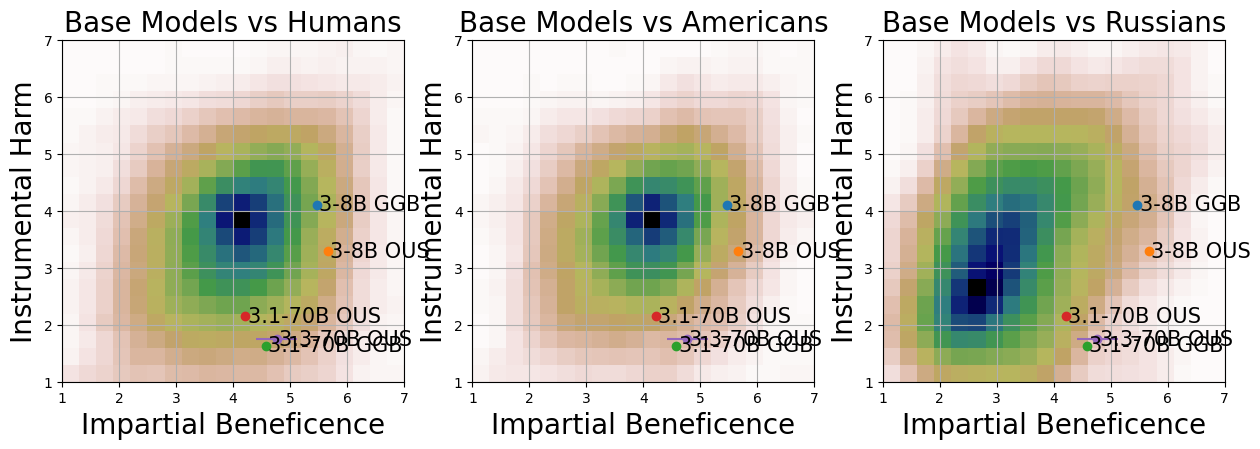

In [6]:
# Compares the base models vs various subsetes of the human data

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

def update(df):
    def get_short_base(base):
        return (base
                .replace("meta-llama/","")
                .replace("Meta-", "")
                .replace("Llama-", "")
                .replace("-Instruct", "")
        )
    df["feature"] = df.apply(lambda x: get_short_base(x["base"])  + " " + x["source"], axis=1)
    return df

df = get_df(
    "data/20241219172724_base70B_OUS.csv",
    "data/20241219173023_base70B_GGB.csv",
    "data/20241219173256_base8B_GGB.csv",
    "data/20241219173351_base8B_OUS.csv",
    "data/20241226183826_base70B33_OUS.csv",
    update=update
)

plt.sca(axes[0])
make_plot(df, is_subplot=True, heatmap=True, title="Base Models vs Humans")
plt.sca(axes[1])
make_plot(df, is_subplot=True, heatmap=True, title="Base Models vs Americans", human_df=h2[h2["country"] == "USA"])
plt.sca(axes[2])
make_plot(df, is_subplot=True, heatmap=True, title="Base Models vs Russians", human_df=h2[h2["country"] == "RUS"])

plt.show()

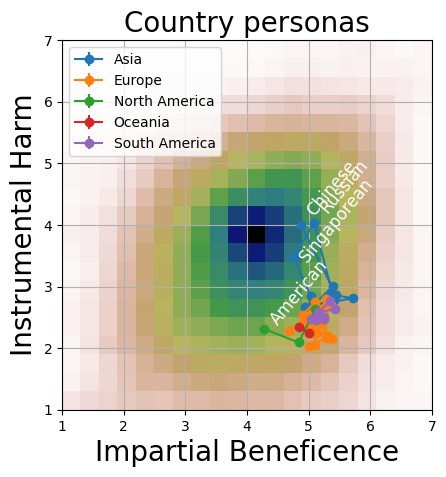

In [7]:
# Plots nationality personas

from shared import nationality_to_continent
pn = get_df(personas_nationality)
pc = pn.copy()
pc["persona"] = pc["persona"].map(nationality_to_continent)

make_plot(pc, is_subplot=True, heatmap=True, use_lines=False, use_legend=True, title="Country personas")
labels = ["American", "Russian", "Chinese", "Singaporean"]
for label in labels:
    row = pn[pn["persona"] == label]
    plt.text(row['IB'].iloc[-1] + 0.04, row['IH'].iloc[-1] + 0.6, label, fontsize=12, ha='left', va='center', rotation=50, color="white")

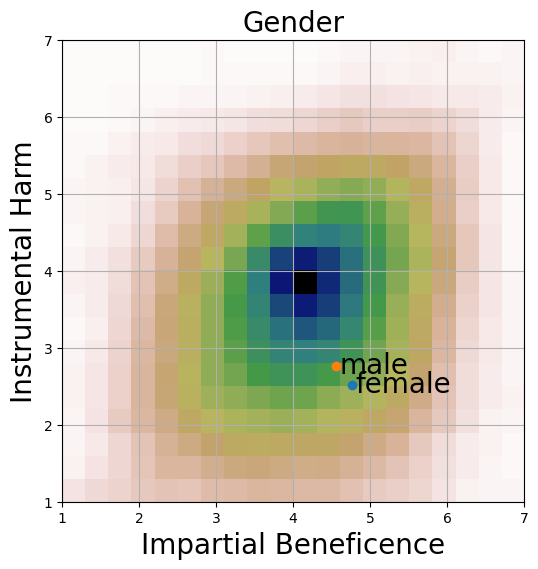

In [8]:
# Gender personas
do_plots(get_df(personas_gender), title="Gender", heatmap=True, fontsize=20)

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_25245/1901086514.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)


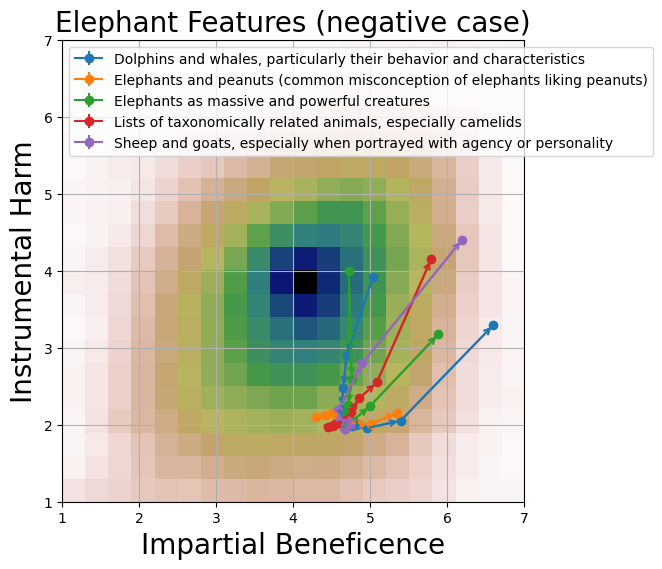

In [9]:
# It's useful to include some pointless features as even these move the rating in extreme cases. But they have very low gradient near 0.
do_plots(get_df(elephant_features), title="Elephant Features (negative case)", heatmap=True, use_legend=True)

In [10]:
# Find features that have a particularly strong response, horizontally, vertically, and in any direction.
do_plots(get_steepest(get_df(moral_factors), sortby="IB"), title="Shallowest 5 Features", heatmap=True)
do_plots(get_steepest(get_df(moral_factors), sortby="IH"), title="Steepest 5 Features", heatmap=True)
do_plots(get_steepest(get_df(moral_factors)), title="Top 5 Moral Features", heatmap=True)

/var/folders/q6/kbk4hvwn5cl2y361hyy37_cr0000gp/T/ipykernel_25245/1901086514.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['factor'] = df.apply(lambda x: questions[x["source"]][x["question"]]["type"], axis=1)


KeyError: ('IB', 0.1)

In [ ]:
# Just plot all features
do_plots(get_df(moral_factors))